In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# # 若无法获得测试数据，则可根据训练数据计算均值和标准差
# numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# print(numeric_features)

# all_features[numeric_features] = all_features[numeric_features].apply(
#     lambda x: (x - x.mean()) / (x.std()))
# # 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
# all_features[numeric_features] = all_features[numeric_features].fillna(0)

# # “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
# all_features = pd.get_dummies(all_features, dummy_na=True)
# all_features.shape
# # 存为 csv
# all_features.to_csv('data/all_features.csv', index=False)

# n_train = train_data.shape[0]
# train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
# test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# print(train_features.shape, test_features.shape, train_labels.shape)

In [33]:
import matplotlib.pyplot as plt
from IPython import display

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        plt.ion()  # 开启交互模式
        self.fig, self.ax = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.ax = [self.ax]
        self.config_axes = lambda: self.set_axes(
            self.ax[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        self.lines = []

    def set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置轴"""
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        if legend:
            ax.legend(legend)
        ax.grid()

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.ax[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.ax[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [34]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.linear1 = nn.Linear(in_channels, out_channels)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(out_channels, out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Linear(in_channels, out_channels),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.linear1(x)))
        out = self.bn2(self.linear2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNetForHousePrice(nn.Module):
    def __init__(self, input_dim, num_blocks, hidden_dim):
        super(ResNetForHousePrice, self).__init__()
        self.in_channels = hidden_dim
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.layers = self._make_layers(num_blocks, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def _make_layers(self, num_blocks, hidden_dim):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(hidden_dim, hidden_dim))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear(x)
        out = self.layers(out)
        out = self.fc(out)
        return out


In [35]:
# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 假设 `train_data` 和 `test_data` 已经加载
# 假设 `all_features` 是包含特征的 DataFrame，`train_data` 是包含房价的 DataFrame
n_train = train_data.shape[0]
all_features = pd.concat((train_data.iloc[:, :-1], test_data.iloc[:, :-1]))

# 对非数值型特征进行独热编码
all_features = pd.get_dummies(all_features)

# 标准化数据
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
scaler = StandardScaler()
all_features[numeric_features] = scaler.fit_transform(all_features[numeric_features])

# 填充缺失值
all_features = all_features.fillna(0)

# 确保所有数据都是数值型
all_features = all_features.astype('float32')

# 将数据转换为张量并移动到 GPU
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32).to(device)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32).to(device)

batch_size = 64
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

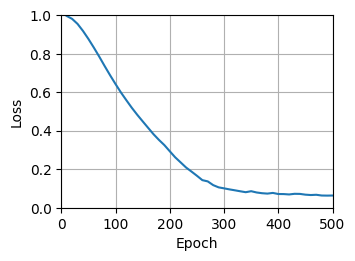

In [36]:
# 定义模型、损失函数和优化器
input_dim = train_features.shape[1]
num_blocks = 3
hidden_dim = 256
model = ResNetForHousePrice(input_dim, num_blocks, hidden_dim).to(device)

# 定义损失函数
class RelativeErrorLoss(nn.Module):
    def __init__(self):
        super(RelativeErrorLoss, self).__init__()

    def forward(self, preds, labels):
        relative_error = torch.abs(preds - labels) / torch.abs(labels)
        return torch.mean(relative_error)

loss_fn = RelativeErrorLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 500

# 使用 Animator 动态绘图
animator = Animator(xlabel='Epoch', ylabel='Loss', xlim=[0, num_epochs], ylim=[0, 1])


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X, y in train_loader:
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')
        # 添加损失到动画
        animator.add(epoch + 1, epoch_loss)


In [38]:
# 评估模型并生成提交文件
model.eval()
with torch.no_grad():
    test_preds = model(test_features).cpu().numpy()

submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': test_preds.flatten()
})
submission.to_csv('submission_resnet.csv', index=False)